In [ ]:
# 2. 정규표현식으로 해시태그를 제거해서 전처리 하는 것 보단 해시태그를 이용한 분석을 하는 것도 좋다고 생각함

In [1]:
import os
import re
import platform

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime
from tqdm import tqdm
from collections import Counter
import swifter
from konlpy.tag import Kkma, Komoran, Okt, Mecab
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def Fontmanager():

    plt.rcParams['axes.unicode_minus'] = False

    if platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Darwin':
        path = '/Library/Fonts/Arial Unicode.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='AppleGothic')
    elif platform.system() == 'Linux':
        path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='NanumBarunGothic')
    else:
        print('Unknown system... sorry~~~~~~')
    print(f"해당 pc의 운영 체제는 {platform.system()}이며 {font_name}로 설정되었습니다")  
    return path

In [4]:
path = Fontmanager()

해당 pc의 운영 체제는 Darwin이며 Arial Unicode MS로 설정되었습니다


In [5]:
women_policy = pd.read_csv('dataset/women_policy_multilabel.csv')
# 혹시 모를 중복제거
women_policy = women_policy.drop_duplicates()

In [6]:
# 혹시 모를 nan값 확인
women_policy.isna().sum()

datetime       0
id             0
text           0
username       0
tokenized      0
label          0
score          0
label_word     0
multi_label    0
dtype: int64

In [7]:
texts = women_policy[women_policy['text'].apply(lambda x : x.startswith('#'))]

In [8]:
texts['text'] = texts['text'].str.split('\n').apply(lambda x : [i for i in x if i.startswith('#') ])
texts['text'] = texts['text'].apply(lambda x: ' '.join(x))
texts['text'] = texts['text'].str.split(' ').apply(lambda x : [i for i in x if i.startswith('#') ])

<ipython-input-8-6b3ef2c31a36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].str.split('\n').apply(lambda x : [i for i in x if i.startswith('#') ])
<ipython-input-8-6b3ef2c31a36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].apply(lambda x: ' '.join(x))
<ipython-input-8-6b3ef2c31a36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [9]:
word_of_Bag = sum(texts['text'], [])

No handles with labels found to put in legend.


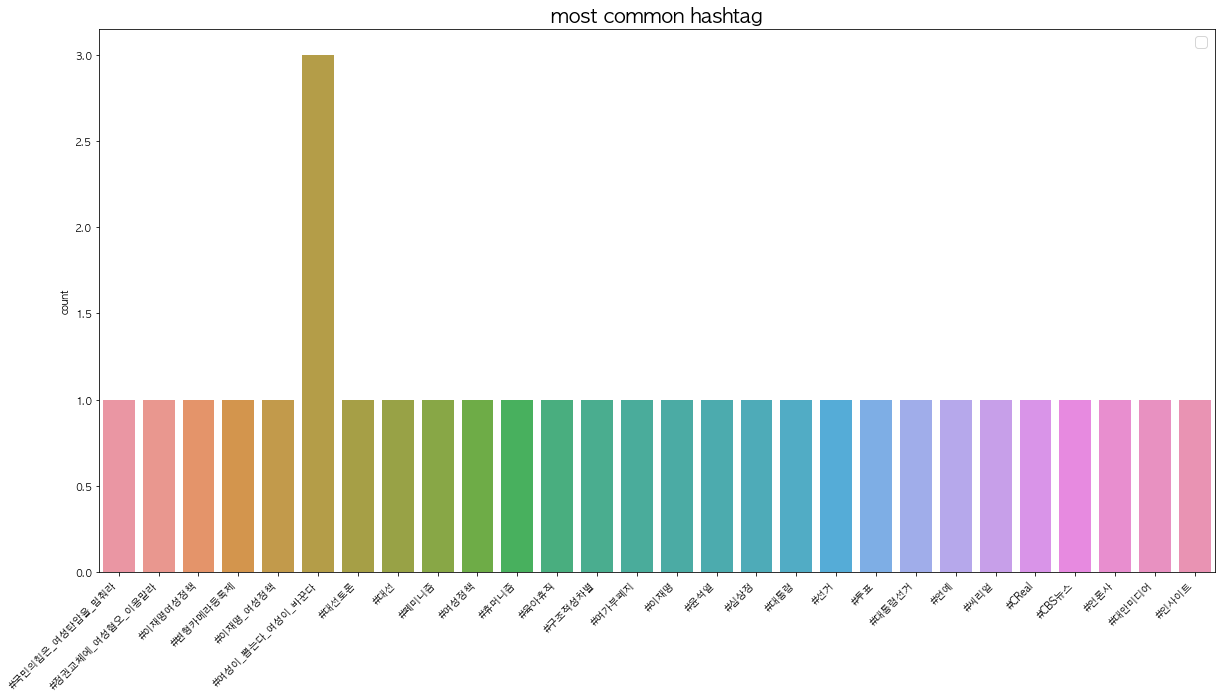

In [10]:
# 해시태그
plt.figure(figsize=(20,10))
plot = sns.countplot(word_of_Bag)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common hashtag', fontsize=20)
plt.legend(fontsize=15)
# save_fig('most common hashtag')

In [11]:
# 정규표현식 이용한 전처리
def clean(text):
    #\n 공백 제거
    text = re.sub('\n',' ',str(text))
    # URL 제거
    text = re.sub('https://[A-Za-z0-9./]*','',str(text))
    # 한글자 제거 (ex:ㅋㅋ, ㅜㅜ)
    text = re.sub('([ㄱ-ㅎㅏ-ㅣ])+', '', str(text))
    # 숫자 제거 (숫자 + 숫자만 제거, ex: 1인가족)
    text= re.sub('[0-9]{2}', '', str(text))
    # @알파벳 제거 
    text = re.sub('@[A-Za-z0-9./]*','',str(text))
    return str(text)

In [12]:
women_policy['text'] = women_policy['text'].apply(lambda x : clean(x))

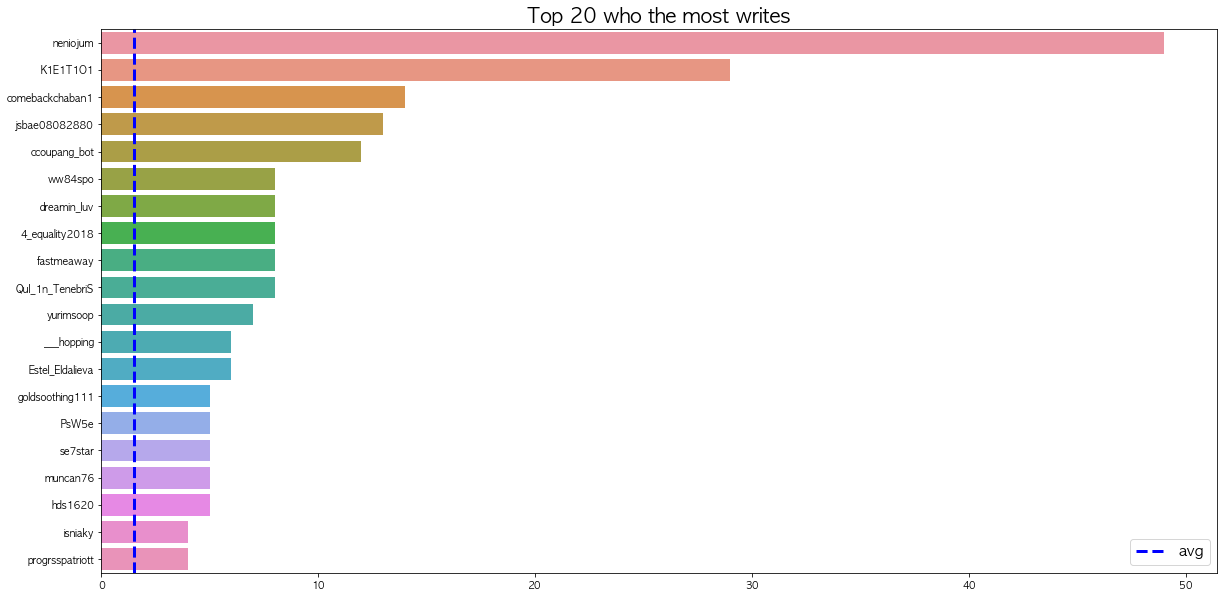

In [13]:
# 어떤 유저가 가장 많이 트윗을 썻는지
plt.figure(figsize=(20,10))
sns.barplot(x=women_policy['username'].value_counts()[:20].values, 
            y=women_policy['username'].value_counts()[:20].index,
           orient='h')
plt.title('Top 20 who the most writes', fontsize=20)
plt.axvline(x=np.average(women_policy['username'].value_counts().values), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
# save_fig('Top 20 who the most writes')

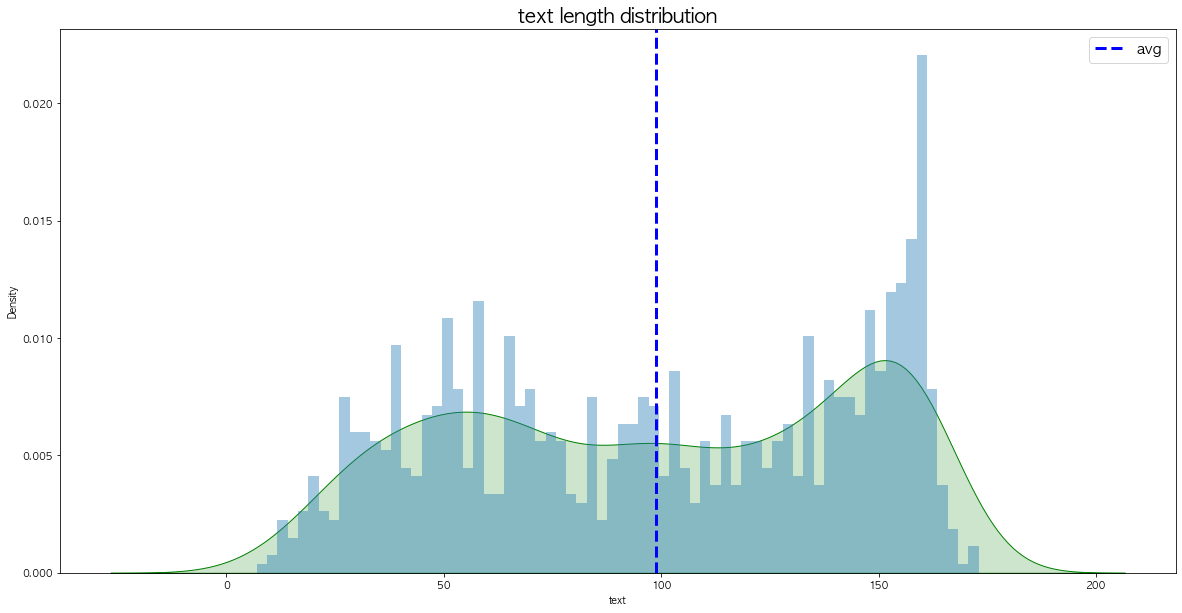

In [14]:
# 전체 문장 길이 분포
plt.figure(figsize=(20,10))
sns.distplot(a=women_policy['text'].str.len(), bins=70, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('text length distribution', fontsize=20)
plt.axvline(x=np.average(women_policy['text'].str.len()), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
#save_fig('text length distribution')

In [15]:
# tokenizer
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

# stopwords list
stop_words = pd.read_csv('dataset/한국어불용어100.txt', sep = "\t", engine='python')
stop_words = list(stop_words["word"])

In [16]:
def preprocessing_mecab(sentence):
    #### Tokenize
    morphs = mecab.pos(sentence)
    
    JOSA = ["JKS", "JKC", "JKG", "JKO", "JKB", "JKV", "JKQ", "JX", "JC"] # 조사
    SIGN = ["SF", "SE", "SSO", "SSC", "SC", "SY"] # 문장 부호
    TERMINATION = ["EP", "EF", "EC", "ETN", "ETM"] # 어미
    SUPPORT_VERB = ["VX"] # 보조 용언
    NUMBER = ["SN"]
    
    # Remove JOSA, EOMI, etc
    morphs[:] = (morph for morph in morphs if morph[1] not in JOSA+SIGN+TERMINATION+SUPPORT_VERB)
        
    # Remove length-1 words  
    morphs[:] = (morph for morph in morphs if not (len(morph[0]) == 1))
    
    # Remove Numbers
    morphs[:] = (morph for morph in morphs if morph[1] not in NUMBER)
   
    # Result pop-up
    result = []
    for morph in morphs:
        result.append(morph[0])
        
    return result

In [17]:
women_policy['tokenized'] = women_policy['text'].apply(lambda x: preprocessing_mecab(x))
women_policy['tokenized'] = women_policy['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])

In [18]:
def common_words(words, k):
    c = Counter(words)
    cw = c.most_common(k)
    return c, cw

In [19]:
def stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word not in stop_words:
            words_new.append(word)
    return words_new

In [20]:
def wordcloud(c):
    wc = WordCloud(font_path='Arial Unicode', width=2000, height=1200, background_color ='white', scale=2.0, max_font_size=250)
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize = (12, 6), facecolor = None) 
    plt.imshow(gen)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # save_fig("most_common_words_wordcloud")

In [21]:
words_sum = sum(women_policy['tokenized'], [])

그림 저장: wordcloud


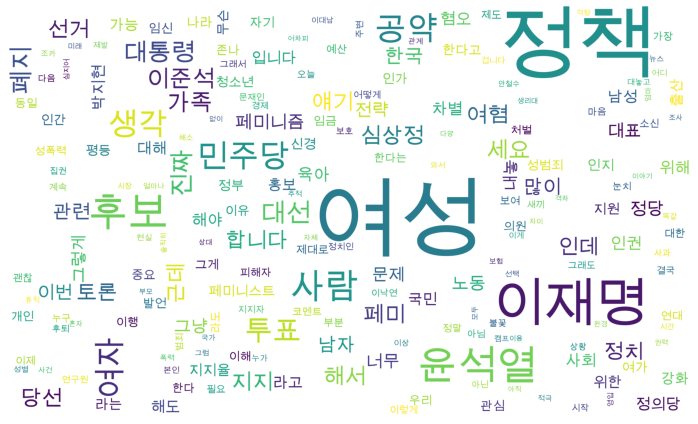

In [22]:
# wordcloud
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud')

In [23]:
stop_words.append('여성')

In [24]:
stop_words.append('정책')

In [25]:
women_policy['tokenized'] = women_policy['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])

그림 저장: wordcloud without


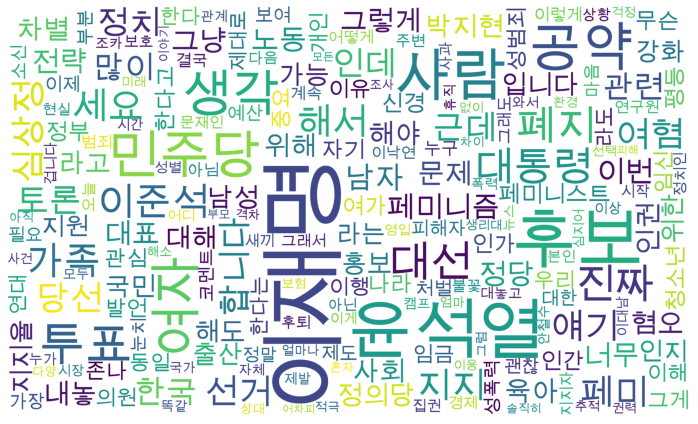

In [26]:
# '여성' '정책' 제외
words_sum = sum(women_policy['tokenized'], [])
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud without')

In [27]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

In [28]:
def plot_word2vec(sentences):
    model = Word2Vec(sentences, size=10, window=3, min_count=10, workers=1)
    word_vectors = model.wv
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]
    
    pca = PCA(n_components=2)
    xy = pca.fit_transform(word_vectors_list)
    x = xy[:, 0]
    y = xy[:, 1]
    
    def plot_2d_graph(vocabs, x, y):
        plt.figure(figsize=(50,50))
        plt.scatter(x, y, marker = 'o')
        for i, v in enumerate(vocabs):
            plt.annotate(v, xy=(x[i], y[i]))
            
    return plot_2d_graph(vocabs, x, y)

In [1]:
class visualize:
    def __init__(self, sentences):
        self.sentences = sentences
        self.vocabs, self.word_vectors_list = word_vectorize()
        self.x, self.y = PCA()
        
    def word_vectorize(self):
        model = Word2Vec(self.sentences, size=10, window=3, min_count=10, workers=1)
        word_vectors = model.wv
        vocabs = word_vectors.vocab.keys()
        word_vectors_list = [word_vectors[v] for v in vocabs]
        return vocabs, word_vectors_list
    
    def PCA(self):
        pca = PCA(n_components=2)
        xy = pca.fit_transform(self.word_vectors_list)
        x = xy[:, 0]
        y = xy[:, 1]
        return x, y
    
    def plot_2d_graph(self):
        plt.figure(figsize=(50,50))
        plt.scatter(self.x, self.y, marker = 'o')
        for i, v in enumerate(self.vocabs):
            plt.annotate(v, xy=(self.x[i], self.y[i]))

In [2]:
sentences = women_policy['tokenized']
visualize(sentences)

NameError: name 'women_policy' is not defined

In [ ]:
sum(sentences.str.len())

In [ ]:
17672**0.25

<ipython-input-30-19e69d248f18>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lee['tokenized'] = lee['tokenized'].apply(lambda x: [item for item in x if item not in stop_words_lee])


그림 저장: wordcloud lee


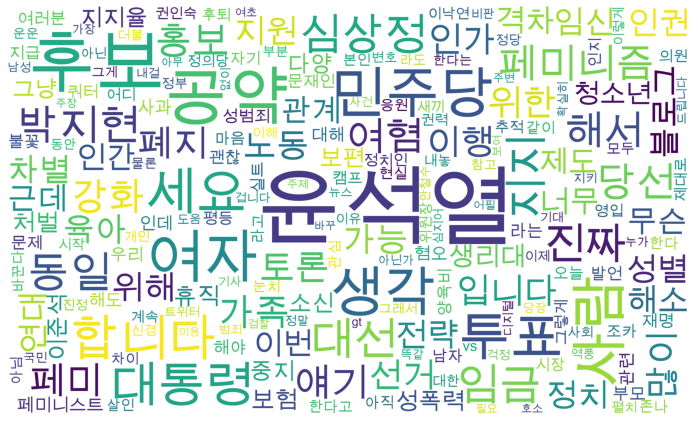

In [30]:
# '이재명' 포함한 문장
stop_words_lee=['이재명']
lee = women_policy[women_policy['text'].str.contains('이재명')]

lee['tokenized'] = lee['tokenized'].apply(lambda x: [item for item in x if item not in stop_words_lee])

# wordcloud
words_sum = sum(lee['tokenized'], [])
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud lee')

In [33]:
lee_df = pd.DataFrame(cw, columns=['keywords', 'count'])

In [47]:
lee_df.head(20)

,keywords,count
0,윤석열,121
1,후보,73
2,공약,62
3,사람,49
4,여자,49
5,민주당,46
6,생각,44
7,투표,42
8,세요,39
9,합니다,37


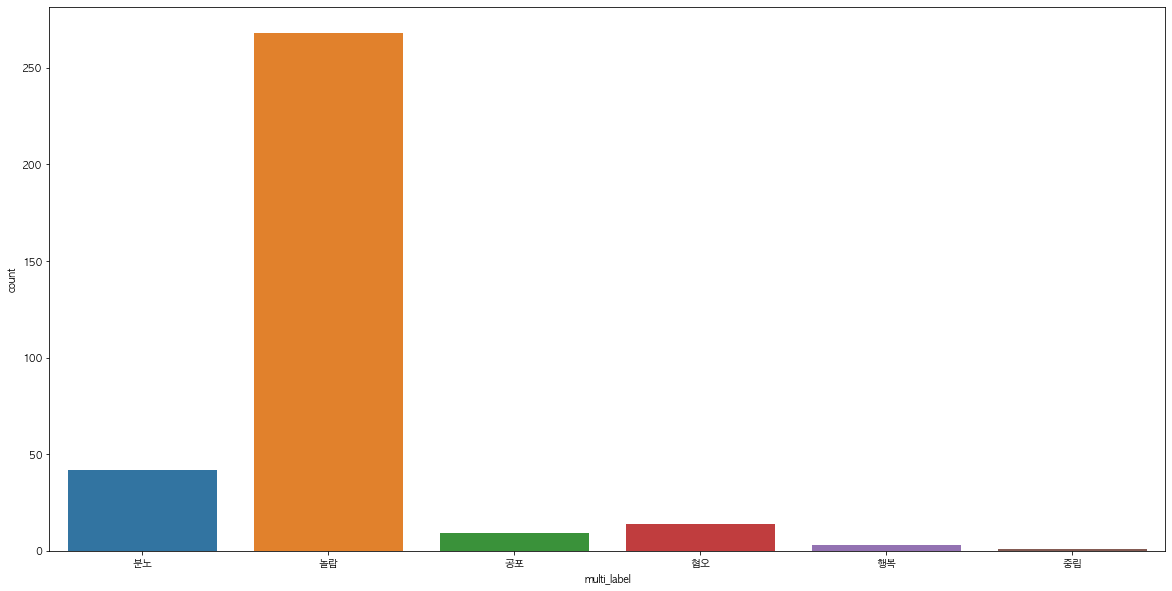

그림 저장: multi label distribution lee


<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize=(20,10))
sns.countplot(lee['multi_label'])
plt.show()
save_fig('multi label distribution lee')

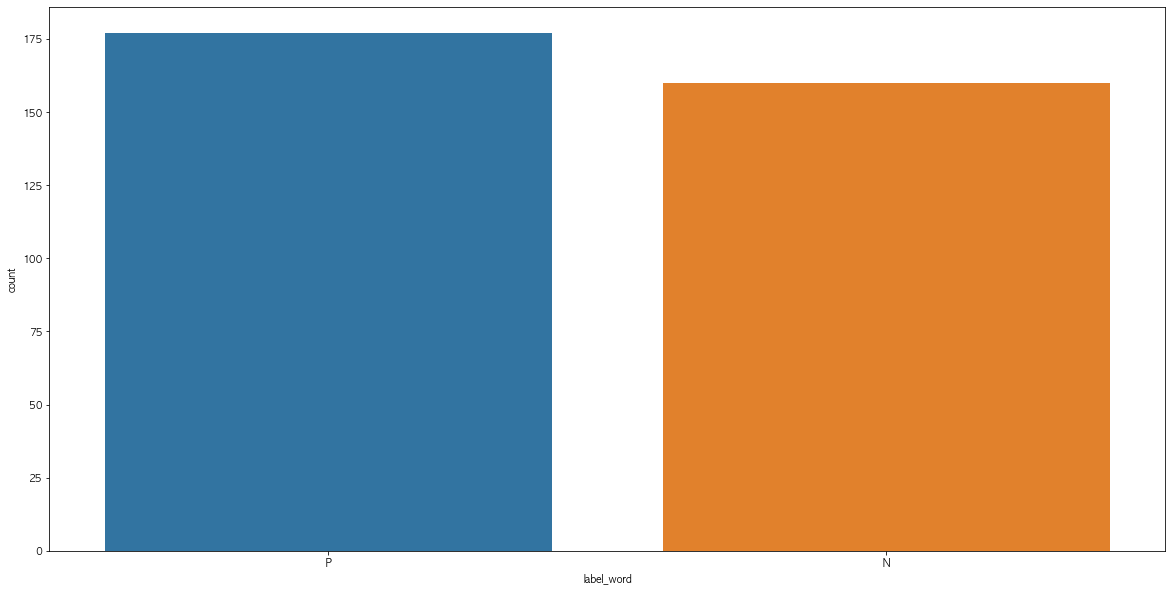

그림 저장: pos neg label distribution lee


<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(figsize=(20,10))
sns.countplot(lee['label_word'])
plt.show()
save_fig('pos neg label distribution lee')

그림 저장: wordcloud lee surprise


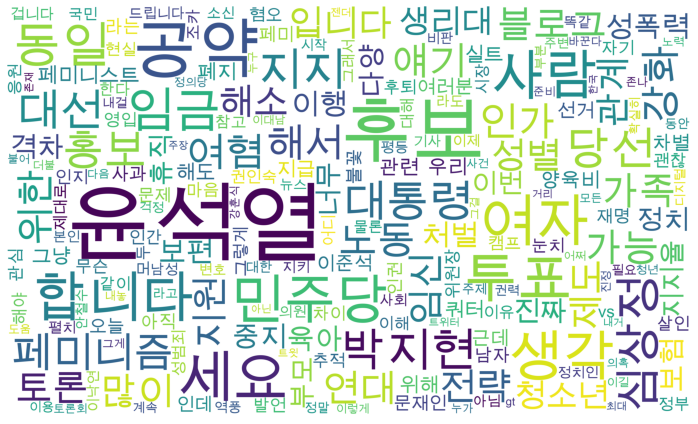

In [38]:
# 놀람
lee_s = lee[lee['multi_label'] == '놀람']

# wordcloud
words_sum = sum(lee_s['tokenized'], [])
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud lee surprise')

In [40]:
lee_s_df = pd.DataFrame(cw, columns=['keywords', 'count'])
lee_s_df

,keywords,count
0,윤석열,92
1,후보,63
2,공약,50
3,여자,36
4,세요,35
...,...,...
195,거리,4
196,젠더,4
197,한국,4
198,아닌,4


그림 저장: wordcloud lee positive


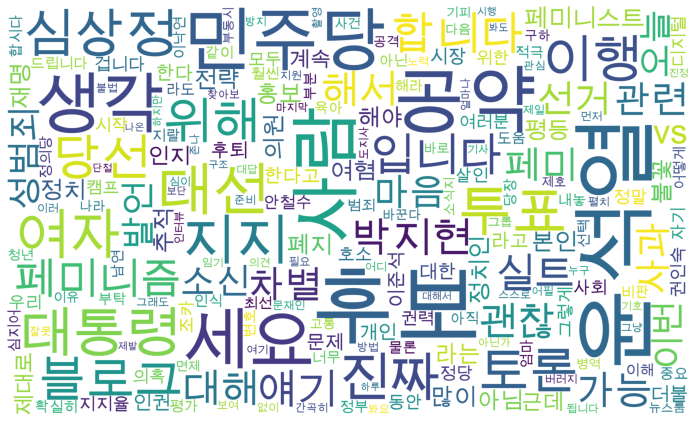

In [41]:
# 긍정
lee_p = lee[lee['label_word'] == 'P']

# wordcloud
words_sum = sum(lee_p['tokenized'], [])
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud lee positive')

In [42]:
lee_p_df = pd.DataFrame(cw, columns=['keywords', 'count'])
lee_p_df

,keywords,count
0,후보,46
1,윤석열,45
2,공약,33
3,사람,30
4,민주당,29
...,...,...
195,하루,3
196,단절,3
197,구조,3
198,보단,3


<ipython-input-82-5b875fafbbdb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youn['tokenized'] = youn['tokenized'].apply(lambda x: [item for item in x if item not in stop_words_youn])


그림 저장: wordcloud youn


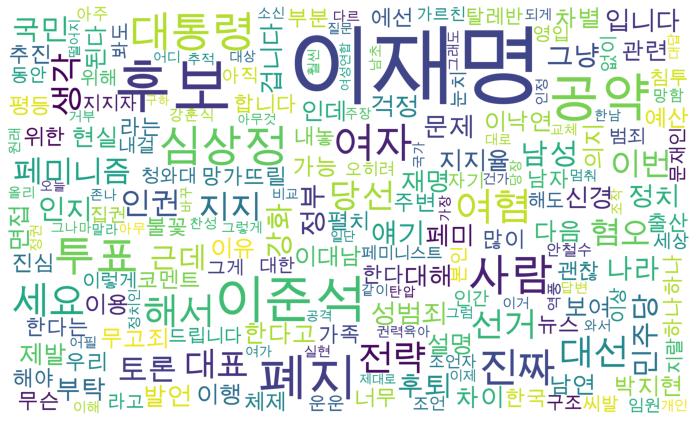

In [82]:
# '윤석열' 포함한 문장
stop_words_youn=['윤석열']
youn = women_policy[women_policy['text'].str.contains('윤석열')]

youn['tokenized'] = youn['tokenized'].apply(lambda x: [item for item in x if item not in stop_words_youn])

# wordcloud
words_sum = sum(youn['tokenized'], [])
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud youn')

In [52]:
youn_df = pd.DataFrame(cw, columns=['keywords', 'count'])
youn_df

,keywords,count
0,이재명,129
1,후보,50
2,공약,38
3,이준석,36
4,폐지,33
...,...,...
195,떨어지,4
196,오늘,4
197,제대로,4
198,여성연합,4


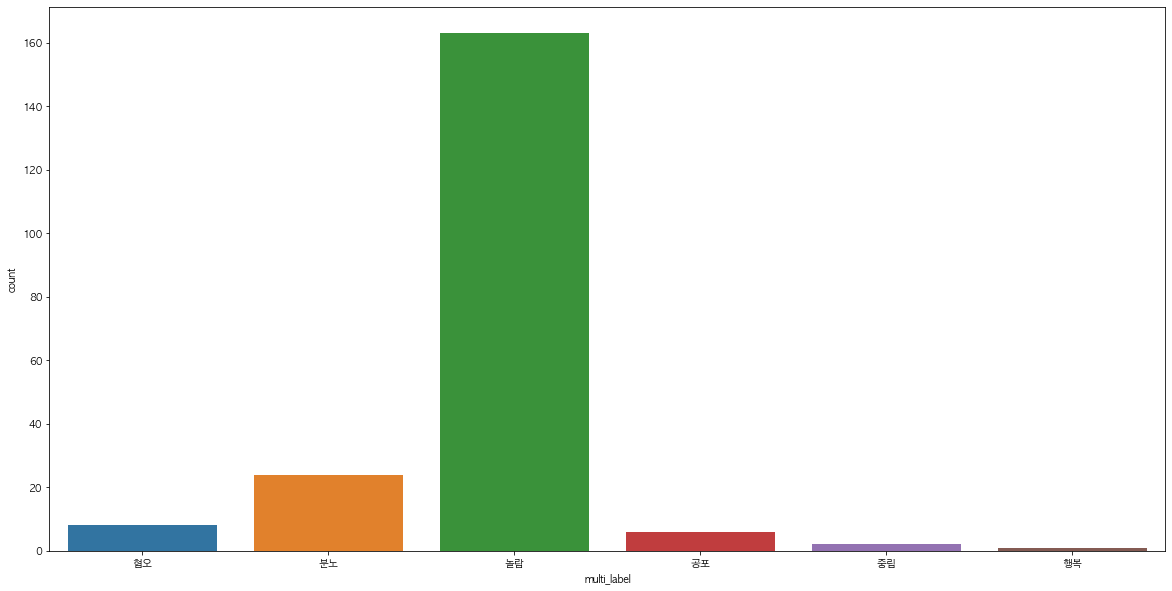

그림 저장: multi label distribution youn


<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=(20,10))
sns.countplot(youn['multi_label'])
plt.show()
save_fig('multi label distribution youn')

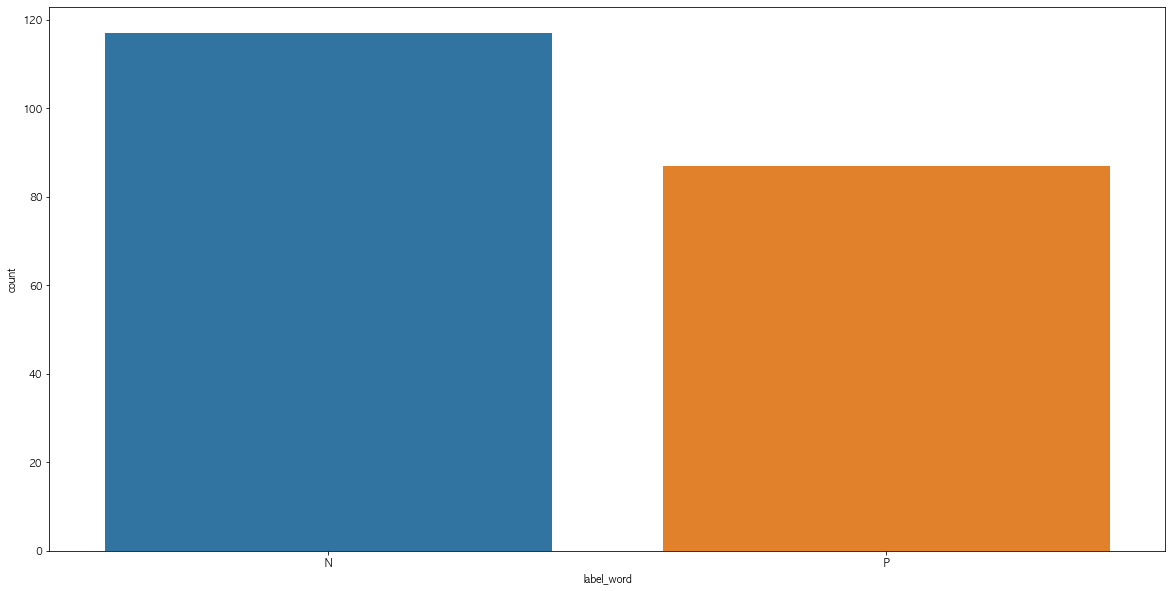

그림 저장: label distribution youn


<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(20,10))
sns.countplot(youn['label_word'])
plt.show()
save_fig('label distribution youn')

In [53]:
women_policy['date'] = pd.to_datetime(women_policy['datetime']).apply(lambda x: x.date())
women_policy['date_re'] = women_policy['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [54]:
date = []
word_list = []
count_list = []
# tokenizing_list = []

for i in women_policy['date_re'].unique():
    tokenizing = sum(women_policy[women_policy['date_re'] == i]['tokenized'],[])
    c, cw = common_words(tokenizing, 1)    
    word = cw[0][0]
    count = cw[0][1]
    date.append(i)
    word_list.append(word)
    count_list.append(count)
    
dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [69]:
def add_value_labels(ax, word, spacing=5):
    for idx, rect in enumerate(ax.patches):
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{0}".format(word[idx])

        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)  

No handles with labels found to put in legend.


그림 저장: most common word by date


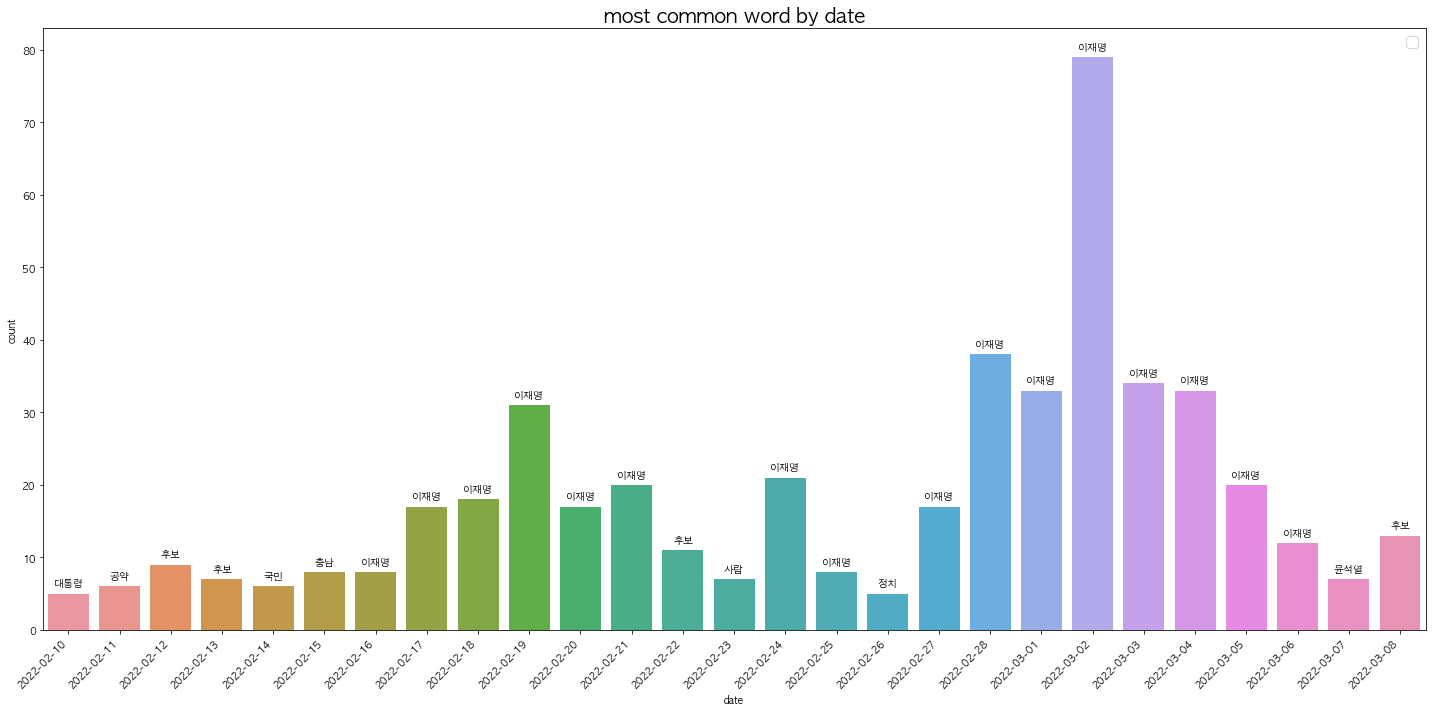

In [74]:
fig, ax = plt.subplots(1, figsize=(20,10))
plot = sns.barplot(test_df['date'], test_df['count'])
add_value_labels(ax, test_df['word'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common word by date', fontsize=20)
plt.legend(fontsize=15)
save_fig("most common word by date")

In [ ]:
# 3월 2일 마지막 티비 토론

No handles with labels found to put in legend.


그림 저장: distribution by date


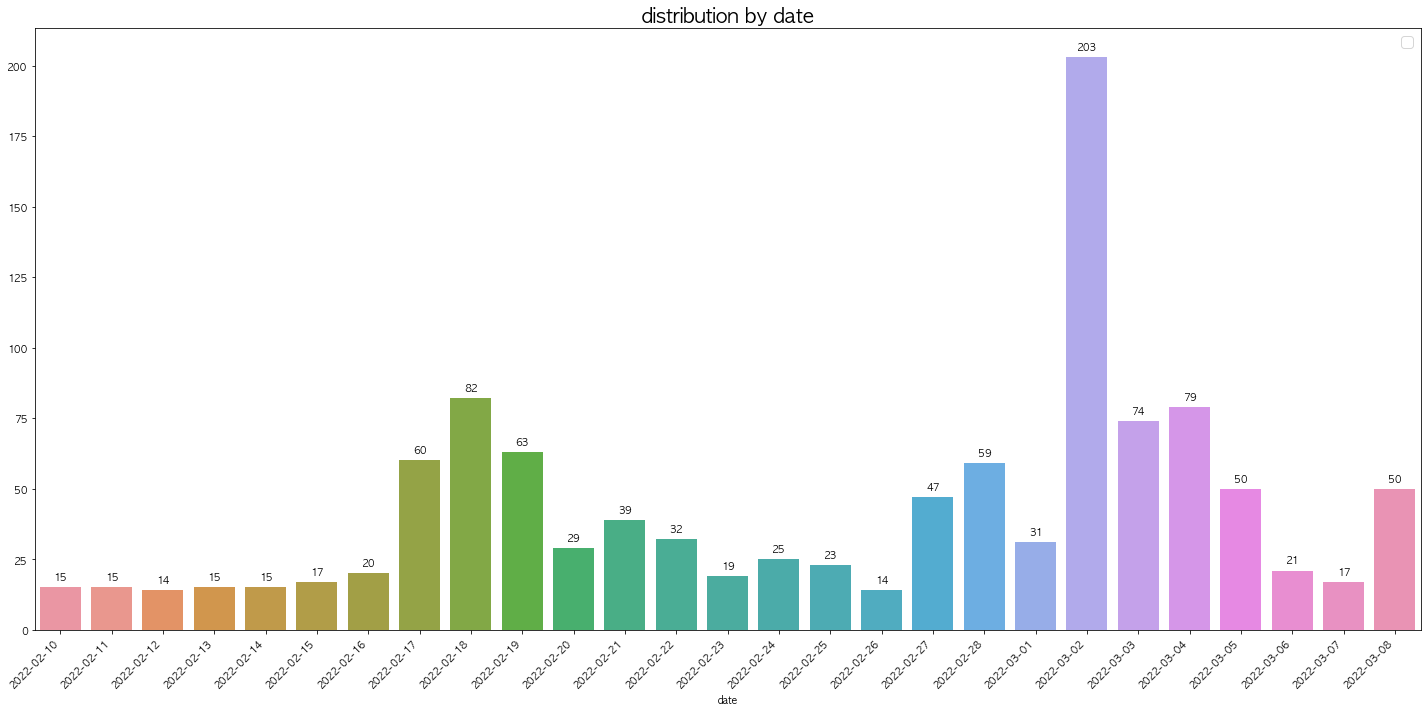

In [73]:
fig, ax = plt.subplots(1, figsize=(20,10))
plot = sns.barplot(women_policy.groupby('date').count()['date_re'].index,
                   women_policy.groupby('date').count()['date_re'].values)
add_value_labels(ax, women_policy.groupby('date').count()['date_re'].values)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('distribution by date', fontsize=20)
plt.legend(fontsize=15)
save_fig("distribution by date")

In [80]:
mar2nd = women_policy[women_policy['date_re'] == '2022-03-02']

그림 저장: wordcloud march 2nd


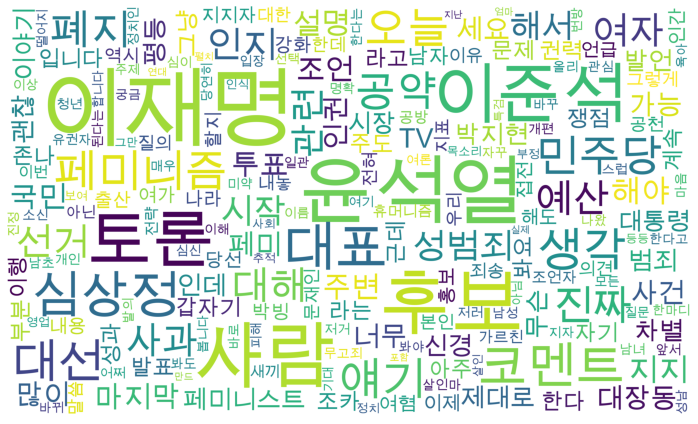

In [85]:
words_sum = sum(mar2nd['tokenized'], [])
c, cw = common_words(words_sum, 200)
wordcloud(c)
save_fig('wordcloud march 2nd')

In [86]:
mar2nd_df = pd.DataFrame(cw, columns=['keywords', 'count'])
mar2nd_df

,keywords,count
0,이재명,79
1,윤석열,59
2,후보,56
3,사람,55
4,이준석,45
...,...,...
195,연대,2
196,포함,2
197,실제,2
198,지난,2


In [ ]:
# tokenizing preprocessing
# okt noun 
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

In [ ]:
# 단어 길이 분포
plt.figure(figsize=(20,10))
sns.distplot(a=nouns.str.len(), bins=30, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('word length distribution', fontsize=20)
plt.axvline(x=nouns.str.len().mean(), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
# save_fig('word length distribution')

In [ ]:
# stopword 단어 분포
def only_stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word in stop_words:
            words_new.append(word)
    return words_new

In [ ]:
words_new = only_stopwords(words, stop_words)

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(words_new)
plt.title('stopword distribution', fontsize=20)
plt.legend(fontsize=15)
save_fig('stopword distribution')

In [ ]:
# ngram exploration
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [ ]:
new = women_policy['text'].str.split()
new = new.values.tolist()

In [ ]:
words = [n for n in new if len(n) > 1] 

In [ ]:
corpus = sum(words, [])

In [ ]:
corpus

In [ ]:
vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)

In [ ]:
test = sum(women_policy['tokenized'], [])

In [ ]:
test

In [ ]:
vec = CountVectorizer(ngram_range=(2,2)).fit(test)

In [ ]:
bag_of_words = vec.transform(corpus)

In [ ]:
sum_words = bag_of_words.sum(axis=0) 

In [ ]:
words_freq = [(word, sum_words[0, idx])  for word, idx in vec.vocabulary_.items()]

In [ ]:
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
top_n_bigrams = words_freq[:10]

In [ ]:
x,y=map(list,zip(*top_n_bigrams))

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=y,y=x)
plt.title('ngram exploration', fontsize=20)
plt.legend(fontsize=15)
save_fig("ngram exploration")

In [ ]:
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

In [ ]:
women_policy['tokenizing'] = nouns

In [ ]:
women_policy['datetime']

In [ ]:
women_policy['date'] = pd.to_datetime(women_policy['datetime']).apply(lambda x: x.date())

In [ ]:
women_policy['date_re'] = women_policy['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [ ]:
date = []
word_list = []
count_list = []
# tokenizing_list = []

for i in women_policy['date_re'].unique():
    tokenizing = sum(women_policy[women_policy['date_re'] == i]['tokenizing'],[])
    c, cw = common_words(tokenizing, 1)    
    word = cw[0][0]
    count = cw[0][1]
    date.append(i)
    word_list.append(word)
    count_list.append(count)
    
dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [ ]:
# dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
# test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [ ]:
def add_value_labels(ax, spacing=5):
    for idx, rect in enumerate(ax.patches):
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{0}".format(test_df['word'][idx])

        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)  

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,10))
plot = sns.barplot(test_df['date'], test_df['count'])
add_value_labels(ax)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common word by date', fontsize=20)
plt.legend(fontsize=15)
save_fig("most common word by date")

# 감성 분석

In [ ]:
women_policy['text_len'] = women_policy['text'].str.len()

In [ ]:
women_policy_p = women_policy[women_policy['label_word'] == 'P']
women_policy_n = women_policy[women_policy['label_word'] == 'N']

In [ ]:
women_policy_p

In [ ]:
# 긍부정 문장 길이
plt.figure(figsize=(20,10))
sns.distplot(women_policy_p['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_n['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})

In [ ]:
# 긍정
words = [n for n in women_policy_p['tokenizing'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [ ]:
# 부정
words = [n for n in women_policy_n['tokenizing'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [ ]:
# multi label data load
women_policy = pd.read_csv('dataset/women_policy_multilabel.csv')

In [ ]:
# label distribution
plt.figure(figsize=(20,10))
sns.countplot(women_policy['multi_label'])

In [ ]:
women_policy['text_len'] = women_policy['text'].str.len()

In [ ]:
women_policy_0 = women_policy[women_policy['multi_label'] == '놀람']
women_policy_1 = women_policy[women_policy['multi_label'] == '분노']
women_policy_2 = women_policy[women_policy['multi_label'] == '혐오']
women_policy_3 = women_policy[women_policy['multi_label'] == '중립']
women_policy_4 = women_policy[women_policy['multi_label'] == '공포']
women_policy_5 = women_policy[women_policy['multi_label'] == '행복']
women_policy_6 = women_policy[women_policy['multi_label'] == '슬픔']

In [ ]:
# 문장 길이
plt.figure(figsize=(20,10))
sns.distplot(women_policy_0['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_1['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_2['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_3['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_4['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_5['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_6['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})

In [ ]:
# 놀람 제외
sns.distplot(women_policy_1['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_2['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_3['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_4['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_5['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})
sns.distplot(women_policy_6['text_len'], bins=30,
             kde=False,
             rug_kws={"color": "r", "alpha": 0.3, "linewidth": 2, "height":0.2})

In [ ]:
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

In [ ]:
def preprocessing_mecab(sentence):
    #### Tokenize
    morphs = mecab.pos(sentence)
    
    JOSA = ["JKS", "JKC", "JKG", "JKO", "JKB", "JKV", "JKQ", "JX", "JC"] # 조사
    SIGN = ["SF", "SE", "SSO", "SSC", "SC", "SY"] # 문장 부호
    TERMINATION = ["EP", "EF", "EC", "ETN", "ETM"] # 어미
    SUPPORT_VERB = ["VX"] # 보조 용언
    NUMBER = ["SN"]
    
    # Remove JOSA, EOMI, etc
    morphs[:] = (morph for morph in morphs if morph[1] not in JOSA+SIGN+TERMINATION+SUPPORT_VERB)
        
    # Remove length-1 words  
    morphs[:] = (morph for morph in morphs if not (len(morph[0]) == 1))
    
    # Remove Numbers
    morphs[:] = (morph for morph in morphs if morph[1] not in NUMBER)
   
    # Result pop-up
    result = []
    for morph in morphs:
        result.append(morph[0])
        
    return result

In [ ]:
wp = women_policy.copy()

In [ ]:
wp['tokenized'] = wp['text'].apply(lambda x: preprocessing_mecab(x))

In [ ]:
wp['tokenized'] = wp['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
stop_words

In [ ]:
wp_0 = wp[wp['multi_label'] == '놀람']
wp_1 = wp[wp['multi_label'] == '분노']
wp_2 = wp[wp['multi_label'] == '혐오']
wp_3 = wp[wp['multi_label'] == '중립']
wp_4 = wp[wp['multi_label'] == '공포']
wp_5 = wp[wp['multi_label'] == '행복']
wp_6 = wp[wp['multi_label'] == '슬픔']

In [ ]:
# 놀람
words = [n for n in wp_0['tokenized'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [ ]:
cw

In [ ]:
new = women_policy_0['tokenized'].str.split()
new = new.values.tolist()
words = [n for n in new if len(n) > 1] 
corpus = sum(words, [])

In [ ]:
# 분노
words = [n for n in wp_1['tokenized'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [ ]:
cw

In [ ]:
# 혐오
words = [n for n in wp_2['tokenized'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [ ]:
cw

In [ ]:
# 중립
words = [n for n in wp_3['tokenized'] if len(n) > 1] 
words = sum(words, [])
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [ ]:
cw

In [ ]:
# 윤석열, 이재명 키워드의 데이터 나눈 후 긍부정 분석

In [ ]:
# topic modeling exploration with pyLDAvis

In [ ]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models

In [ ]:
corpus = []
stem = PorterStemmer()
lem = WordNetLemmatizer()
for news in text :
    words = [w for w in word_to]

In [ ]:
nouns.str.len().mean()

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).hist()

In [ ]:
mecab.nouns(women_policy['text'][0])

In [ ]:
nouns = women_policy['text'].swifter.apply(lambda x : mecab.nouns(x))

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
wordcloud(c)

In [ ]:
np.concatenate(women_policy['text'].tolist()).tolist()

In [ ]:
women_policy['text'].tolist()

In [ ]:
women_policy['text'].swifter.apply(lambda x : komoran.nouns(x))

In [ ]:
len(women_policy['text'])

In [ ]:
word_list = []
for i in range(len(women_policy['text'])):
    word = mecab.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
word_list = []
for i in range(15):
    word = komoran.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
new_word_list = np.concatenate(word_list).tolist()

In [ ]:
words = [n for n in new_word_list if len(n) > 1] 

In [ ]:
words

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
words_new

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
= np.concatenate(word_list).tolist()

In [ ]:
len(women_policy['text'])

In [ ]:
word = komoran.nouns(women_policy['text'][0])
word

In [ ]:
women_policy['text'][0]

In [ ]:
komoran.pos(women_policy['text'].tolist())